# 전라남도 개별/공동주택 + 인구데이터 전처리

### 사용 라이브러리

In [1]:
# 필요한 라이브러리 로드
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns

## 개별/공동주택 데이터
주택데이터에서 지번별 총 면적을 추출하여 인구 밀도를 어렴풋이나마 계산해주고자 하였다.

사용된 데이터는 2024년 1월에 조회된 전라남도 내의 개별/공동주택 데이터이다.

In [2]:
# 필요한 컬럼만 추출
shared_cols = ['고유번호', '법정동코드', '법정동명', '지번', '특수지구분코드', '특수지구분명', '전용면적']
private_cols = ['고유번호', '법정동코드', '법정동명', '지번', '특수지구분코드', '특수지구분명', '건물산정연면적']

# 전남 주택가격정보 데이터 불러오기
raw_jeonnam_shared = pd.read_csv('./data/전남_공동주택가격정보.csv', encoding='cp949', low_memory=False, usecols=shared_cols)
raw_jeonnam_private = pd.read_csv('./data/전남_개별주택가격정보.csv', encoding='cp949', low_memory=False, usecols=private_cols)

### 주택 데이터 전처리 함수

In [3]:
def process_housing_data(df):
    """데이터프레임의 '법정동명'과 '지번' 컬럼을 합쳐 '주소' 컬럼을 만들고, '지번별 연면적'을 계산하는 함수"""
    
    # "지번" 컬럼에서 -를 기준으로 분리
    df['지번본번'] = df['지번'].str.split('-').str[0]
    
    # 법정동명과 지번을 합친 "주소" 컬럼을 만들어 반환
    df['주소'] = df['법정동명'] + ' ' + df['지번']
    
    # 지번별 총 연면적을 계산
    try:
        df['지번별 연면적'] = df.groupby(['주소'])['전용면적'].transform('sum')
        df = df.drop('전용면적', axis=1)
    except:
        df['지번별 연면적'] = df.groupby(['주소'])['건물산정연면적'].transform('sum')
        df = df.drop('건물산정연면적', axis=1)
    
    # 주소가 중복되는 행을 제거
    df = df.drop_duplicates(['주소'])
    
    # NaN 값이 있는 행을 제거
    df = df.dropna()
    
    return df

In [4]:
# 데이터 프레임 정리
df_housing_private = process_housing_data(raw_jeonnam_private)
df_housing_shared = process_housing_data(raw_jeonnam_shared)

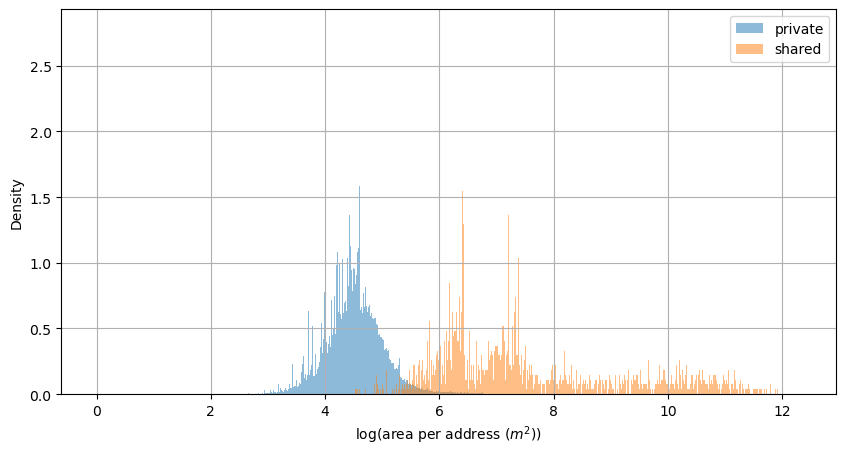

In [5]:
# 지번본번별 연면적 시각화, 분포 그래프로 확인
plt.figure(figsize=(10, 5))
plt.hist(df_housing_private['지번별 연면적'].apply(lambda x: np.log(x+1)), bins=1000, density=True, alpha=0.5, label='private')
plt.hist(df_housing_shared['지번별 연면적'].apply(lambda x: np.log(x+1)), bins=1000, density=True, alpha=0.5, label='shared')
plt.grid(True)
plt.xlabel('log(area per address $(m^2)$)')
plt.ylabel('Density')
plt.legend()
plt.show()

In [6]:
# 전남 개별주택과 공동주택 데이터를 주소 컬럼을 기준으로 병합
df_housing = pd.merge(df_housing_private, df_housing_shared[['주소', '지번별 연면적']], 
                      on='주소', how='inner', suffixes=('_private', '_shared'))

# 총 지번별 연면적 계산
df_housing['지번별 연면적'] = df_housing['지번별 연면적_private'] + df_housing['지번별 연면적_shared']
df_housing.drop(['지번별 연면적_private', '지번별 연면적_shared'], axis=1, inplace=True)

## 지번별 거주 인구수 추정
한국 전체 기준 1인당 평균 주거 면적이 2020년 기준 33.9 $m^2$ 이다.

지번 내의 총 면적을 33.9 $m^2$로 나누어 **지번별 추정 인구수**를 계산해 주도록 하겠다.

In [7]:
# 지번별 연면적을 1인당 평균 주거면적으로 나눔
df_housing['지번별 추정 인구수'] = (df_housing['지번별 연면적'] / 33.9)
df_housing[['지번별 연면적','지번별 추정 인구수']].describe()

,지번별 연면적,지번별 추정 인구수
count,31.000000,31.000000
mean,4049.081935,119.441945
std,10253.242576,302.455533
min,307.230000,9.062832
25%,419.405000,12.371829
50%,1218.820000,35.953392
75%,3561.690000,105.064602
max,57038.950000,1682.564897


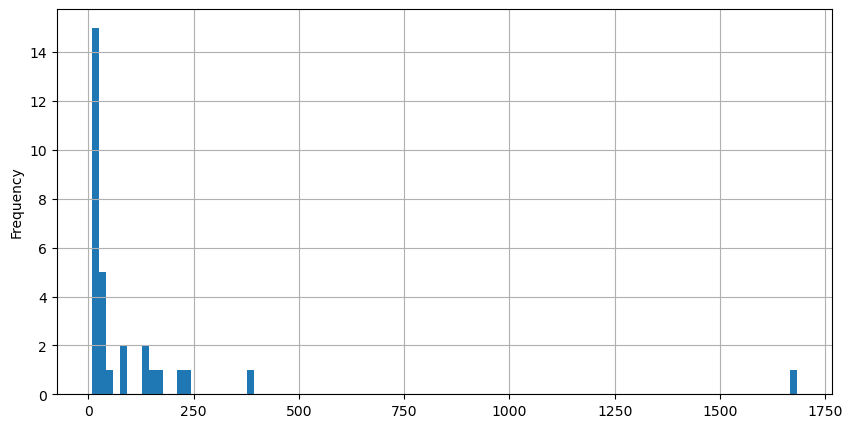

In [8]:
# 주소별 추정 인구수 분포를 log를 씌워 시각화
plt.figure(figsize=(10, 5))
df_housing['지번별 추정 인구수'].plot(kind='hist', bins=100, grid=True)
plt.show()

---

## 전라남도 인구 데이터 전처리
전라남도의 각 법정동 별 총인구수랑 70세이상 인구 비율을 추출해주겠습니다.

In [9]:
# 총 읍면동 별 인구 데이터 불러오기
raw_pop = pd.read_csv('./data/전국_202401_70세_이상_인구통계_법정동.csv', encoding='utf-8-sig')
raw_pop.columns

Index(['법정동코드', '기준연월', '시도명', '시군구명', '읍면동명', '리명', '계', '남자', '여자', '0세남자',
       ...
       '101세여자', '102세여자', '103세여자', '104세여자', '105세여자', '106세여자', '107세여자',
       '108세여자', '109세여자', '110세이상 여자'],
      dtype='object', length=231)

### 필요한 컬럼/행 추출

In [10]:
# 전남 데이터만 추출
raw_pop = raw_pop[raw_pop['시도명'].str.contains('전라남도')]

# 70세 이상 남, 녀, 총 데이터만 추출
raw_pop['70세이상 남자'] = raw_pop.loc[:,'70세남자':'110세이상 남자'].sum(axis=1)
raw_pop['70세이상 여자'] = raw_pop.loc[:,'70세여자':'110세이상 여자'].sum(axis=1)
raw_pop['70세이상 계'] = raw_pop['70세이상 남자'] + raw_pop['70세이상 여자']

# 필요한 열들만 추출
interested_columns = ['법정동코드', '시도명', '시군구명', '읍면동명', '리명', '계', '70세이상 계']

# 전남 데이터프레임 생성
df_pop = raw_pop[interested_columns]

### 70세이상 인구비율 계산

In [11]:
# 70세 이상 인구 비율 계산
df_pop['70세이상 인구비율'] = df_pop['70세이상 계'] / df_pop['계'] * 100

지금의 데이터는 읍면동-리 까지 구분이 되어있기 때문에, 동일한 기준 적용을 위해 읍면동까지만 구분된 인구 데이터도 계산해 준다.

In [12]:
# 읍면동 기준의 총인구 및 70세이상 인구 계산
df_pop[['읍면동 총인구', '읍면동 70세이상 인구']] = df_pop.groupby(['시도명', '시군구명', '읍면동명'])[['계', '70세이상 계']].transform('sum')

In [13]:
# 컬럼명 변환
df_pop.columns = ['법정동코드', '시도명', '시군구명', '읍면동명', '리명', 
                      '읍면동리 총인구', '읍면동리 70세이상 인구', ' 읍면동리 70세이상 인구비율',
                      '읍면동 총인구', '읍면동 70세이상 인구']

# 최종 데이터프레임 확인
df_pop.head()

,법정동코드,시도명,시군구명,읍면동명,리명,읍면동리 총인구,읍면동리 70세이상 인구,읍면동리 70세이상 인구비율,읍면동 총인구,읍면동 70세이상 인구
7569,4611010100,전라남도,목포시,용당동,용당동,12477,3024,24.236595,12477,3024
7570,4611010200,전라남도,목포시,산정동,산정동,41280,7389,17.899709,41280,7389
7571,4611010300,전라남도,목포시,연산동,연산동,13039,1129,8.658639,13039,1129
7572,4611010400,전라남도,목포시,대성동,대성동,3899,525,13.464991,3899,525
7573,4611010500,전라남도,목포시,양동,양동,1318,365,27.693475,1318,365


---

## 인구 + 지번별 면적/추정인구 데이터 병합

In [14]:
# 법정동코드를 기준으로 데이터를 병합
df_final = pd.merge(df_housing.drop(['법정동명', '지번본번', '특수지구분코드', '특수지구분명'], axis=1),
                    df_pop, on='법정동코드', how='left')
df_final.head()

,고유번호,법정동코드,지번,주소,지번별 연면적,지번별 추정 인구수,시도명,시군구명,읍면동명,리명,읍면동리 총인구,읍면동리 70세이상 인구,읍면동리 70세이상 인구비율,읍면동 총인구,읍면동 70세이상 인구
0,4611010200103260010,4611010200,326-10,전라남도 목포시 산정동 326-10,12805.50,377.743363,전라남도,목포시,산정동,산정동,41280,7389,17.899709,41280,7389
1,4611015900103670001,4611015900,367-1,전라남도 목포시 용해동 367-1,4279.20,126.230088,전라남도,목포시,용해동,용해동,26681,3124,11.708707,26681,3124
2,4611015900109660007,4611015900,966-7,전라남도 목포시 용해동 966-7,4820.40,142.194690,전라남도,목포시,용해동,용해동,26681,3124,11.708707,26681,3124
3,4611016000107730001,4611016000,773-1,전라남도 목포시 석현동 773-1,1261.27,37.205605,전라남도,목포시,석현동,석현동,18620,1363,7.320086,18620,1363
4,4613012000100040001,4613012000,4-1,전라남도 여수시 문수동 4-1,1648.80,48.637168,전라남도,여수시,문수동,문수동,19241,2490,12.941115,19241,2490


In [17]:
# 예측 값이랑 실제 값이랑 비교
df_final['읍면동리별 추정 인구수'] = df_final.groupby(['법정동코드'])['지번별 추정 인구수'].transform('sum')

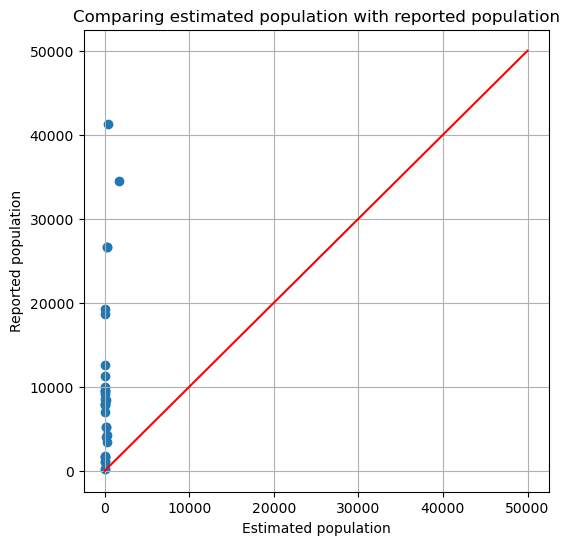

In [19]:
# 법정동 별 추정 인구수와 법정동 총 인구를 시각화하여 비교
plt.figure(figsize=(6, 6))
plt.scatter(df_final['읍면동리별 추정 인구수'], df_final['읍면동리 총인구'])

# y=x 그래프 추가
plt.plot([0, 50000], [0, 50000], 'r')

plt.grid(True)
plt.title('Comparing estimated population with reported population')
plt.xlabel('Estimated population')
plt.ylabel('Reported population')
plt.show()

주택 면적으로 통해 예측한 추정 인구수가 실제 법정동 총 인구수와 비슷하게 나타나는 것을 확인할 수 있습니다.

이는 주택 면적을 인구 밀집도의 지표로 쓸 수 있다는 것을 보여줍니다.

이렇게 개별+공동주택 데이터를 가져와 해당 주소별 연면적을 계산하고, 이 정보가 해당 지역의 인구 밀집도랑 상관계수가 높은 수치인 것을 보여주었습니다.

In [22]:
df_final.drop('읍면동리별 추정 인구수', axis=1).to_csv('jeonnam_housing_pop.csv', encoding='cp949', index=False)

In [23]:
df_final.describe()

,법정동코드,특수지구분코드,지번별 연면적 합,지번별 추정 인구수,읍면동리 총 인구수,읍면동리 70세이상 인구수,읍면동리 70세이상 인구비율,읍면동 총 인구수,읍면동 총 70세이상 인구수,읍면동 70세이상 인구비율,읍면동리별 추정 인구수
count,3.888370e+05,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000,388837.000000
mean,4.660198e+09,1.008518,176.000111,5.191744,2898.362520,448.315533,30.119516,7813.648339,1480.379143,28.299795,3075.540090
std,3.159996e+07,0.092177,1880.319316,55.466646,7766.644224,1089.862453,10.305730,10645.057624,1261.766378,9.597160,7980.121229
min,4.611010e+09,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,4.000000,0.000000,0.000000,1.368732
25%,4.617032e+09,1.000000,66.000000,1.946903,216.000000,76.000000,24.050046,2300.000000,775.000000,21.037806,316.084661
50%,4.678025e+09,1.000000,89.340000,2.635398,370.000000,123.000000,31.531532,3382.000000,1069.000000,30.788006,525.171091
75%,4.684025e+09,1.000000,119.260000,3.517994,1017.000000,266.000000,37.267081,8527.000000,1773.000000,35.543657,1157.435398
max,4.691042e+09,6.000000,226185.570000,6672.140708,48540.000000,7389.000000,66.666667,56142.000000,7389.000000,49.090909,47667.700590


---